In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn import preprocessing

PATH = '/home/tbrownex/data/Hackett/JLP/UseCase2/'
FILE = 'BranchSalesDriver'

In [2]:
df = pd.read_csv(PATH+FILE)

ppc          = df["PPC Spend"]
onlineSales  = df["Online Sales"]

ppc   = np.array(ppc).reshape([-1,1])
os    = np.array(onlineSales).reshape([-1,1])
OSmean   = os.mean()
OSstd    = os.std()

In [3]:
# Optimizer likes data with values around 1 so scale using Zscore
ppcScaled = preprocessing.scale(ppc)
osScaled  = preprocessing.scale(os)

Before Scaling:
PPC  ranges from   240 -   611
Sales range from 3,393 - 7,448


After scaling
PPC  ranges from -1.80 - 3.18
Sales range from -1.94 - 3.23


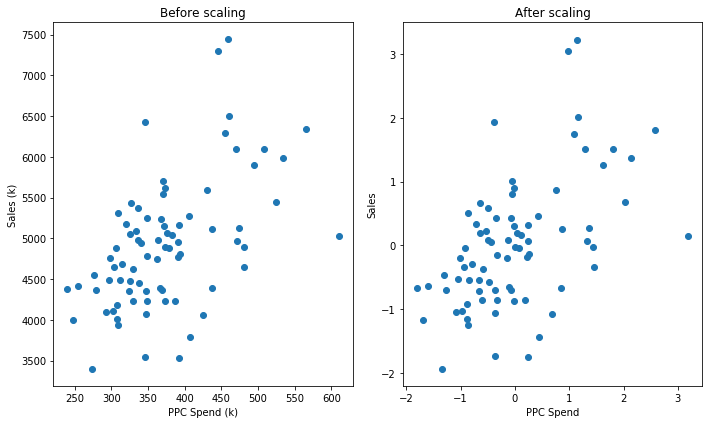

In [4]:
# Print the before and after scaling
print("Before Scaling:")
print("PPC  ranges from   {:,.0f} -   {:,.0f}".format(ppc.min()/1000, ppc.max()/1000))
print("Sales range from {:,.0f} - {:,.0f}".format(os.min()/1000, os.max()/1000))
print("\n")
print("After scaling")
print("PPC  ranges from {:,.2f} - {:,.2f}".format(ppcScaled.min(), ppcScaled.max()))
print("Sales range from {:,.2f} - {:,.2f}".format(osScaled.min(), osScaled.max()))

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(ppc/1000, os/1000)
plt.title("Before scaling")
plt.xlabel("PPC Spend (k)")
plt.ylabel("Sales (k)")

plt.subplot(1, 2, 2)
plt.title("After scaling")
plt.scatter(ppcScaled, osScaled)
plt.xlabel("PPC Spend")
plt.ylabel("Sales")

plt.tight_layout()
plt.show()

In [5]:
# Define the curve-fitting function with parameters to be optimized
def lsq(parms):
    a = parms[0]
    b = parms[1]
    tmp = a*np.exp(b * ppcScaled) - osScaled
    return np.sum(tmp**2)

##### Fit the curve

In [27]:
print("{:<16}{}".format("Method", "LSQ"))
parms = [1, -0.9]
meths = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", \
         "COBYLA",  "SLSQP"]
for meth in meths:
    res = minimize(lsq, parms, method=meth)
    print("{:<15}{:.3f}".format(meth, res.fun))

Method          LSQ
Nelder-Mead    70.151
Powell         70.152
CG             70.151
BFGS           70.151
L-BFGS-B       70.151
TNC            71.034
COBYLA         71.034
SLSQP          70.151


/home/tbrownex/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/tbrownex/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  


In [29]:
# Use the optimized parameters to generate Model values
a = res.x[0]
b = res.x[1]

print(res.message)
#print("Parms are:")
#print("a: {:,.2f}, b: {:,.3f}".format(a,b))

Optimization terminated successfully.


##### Generate the model values for the PPC spend amounts

In [36]:
def lsqError():
    sumErrors = 0
    for s in osScaled:
        err = a*np.exp(b * s) - s
        sumErrors += err * err
    return sumErrors

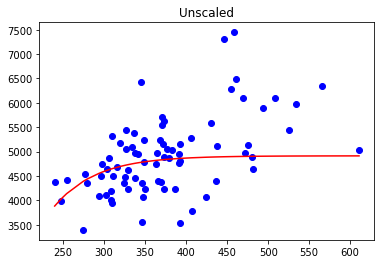

In [30]:
# Sort for plotting: you get a line instead of a scatter plot
ppcSorted = np.sort(ppcScaled, axis=0)
model     = a*np.exp(b * ppcSorted)

# Unscale the model values and overlay with actual
model = model*OSstd+OSmean

plt.scatter(ppc/1000, os/1000, color="b")

ppc   = np.sort(ppc, axis=0)

plt.plot(ppc/1000, model/1000, color="r")
plt.title("Unscaled")
plt.show()

##### Compute error

In [37]:
print(lsqError())

[56.47829318]
